# Rainfall forecasting using BidirectionalLSTM

In [1]:
# Author: Geethu Thottungal Harilal
# data from : https://power.larc.nasa.gov/data-access-viewer/


# This code will use the preprocessed daily data of 1981-2023 of all four regions after 
# feature selection and forecast rainfall using Bidirectional LSTM Method based on the hyperparameter selected.
# It also provide visualisation plot for training and validation loss, predicted vs original, and forecasted and original values
# This code calculates the evaluation matrix such as MAE, RMSE and loss values

In [1]:
#import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [34]:
# read data 
data_en=pd.read_csv("England_dataset_final_1981-2023.csv",parse_dates=["date"]) #England
data_wl=pd.read_csv("Wales_dataset_final_1981-2023.csv",parse_dates=["date"]) #wales
data_sc=pd.read_csv("Scotland_dataset_final_1981-2023.csv",parse_dates=["date"]) #scotland
data_ir=pd.read_csv("Ireland_dataset_final_1981-2023.csv",parse_dates=["date"]) #ireland

## England

In [4]:
target_col = 'Rainfall'

# Extract the target variable
target_en = data_en[target_col].values
df_dates = data_en['date']
df_en =data_en.drop(columns=['date'])

In [5]:
#split test and train
train_split=round(len(df_en)*0.67)
df_for_training_en=df_en[:train_split]
df_temp_en=df_en[train_split:]
test_split=round(len(df_temp_en)*0.5)
df_for_validation_en=df_temp_en[:test_split]
df_for_testing_en=df_temp_en[test_split:]

In [6]:
print("df_for_training Shape-- ",df_for_training_en.shape)
print("df_for_validation Shape-- ",df_for_validation_en.shape)
print("df_for_testing Shape-- ",df_for_testing_en.shape)

df_for_training Shape--  (10419, 7)
df_for_validation Shape--  (2566, 7)
df_for_testing Shape--  (2566, 7)


In [7]:
#split test dates
temp_date=df_dates[train_split:]
df_for_testdate=temp_date[test_split:]

In [8]:
# scale the dataset with minmaxscaler within the range 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled_en = scaler.fit_transform(df_for_training_en)
df_for_validation_scaled_en = scaler.fit_transform(df_for_validation_en)
df_for_testing_scaled_en=scaler.transform(df_for_testing_en)

In [9]:
# Define the number of time steps and features
n_steps = 30  # Number of time steps to consider
n_features = df_for_testing_scaled_en.shape[1]

In [10]:
# split the data in X and Y
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #print(i)
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX_en,trainY_en=createXY(df_for_training_scaled_en,n_steps)
valX_en,valY_en=createXY(df_for_validation_scaled_en,n_steps)
testX_en,testY_en=createXY(df_for_testing_scaled_en,n_steps)

In [11]:
print("trainX Shape-- ",trainX_en.shape)
print("trainY Shape-- ",testX_en.shape)

trainX Shape--  (10389, 30, 7)
trainY Shape--  (2536, 30, 7)


In [12]:
df_for_testdate = df_for_testdate.reset_index()

In [13]:
# split the date
def createtestDate(dataset,n_past):
    dateTest = []
    for i in range(n_past, len(dataset)):
            #print(i)
            dateTest.append(dataset.date[i])
    return np.array(dateTest)
dateTest=createtestDate(df_for_testdate,n_steps)

## Rainfall Forecasting Using Bidirectional LSTM implementation

In [14]:
# design network
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(units=100,activation='sigmoid',return_sequences=True, input_shape=(n_steps,n_features))))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1,activation='tanh'))
opt = optimizers.Adam(learning_rate=0.001)
lstm_model.compile(loss = 'mse',optimizer = opt)

In [15]:
# fit network
history = lstm_model.fit(trainX_en, trainY_en, epochs=50, batch_size=72, validation_data=(valX_en, valY_en), verbose=2, shuffle=False)

Epoch 1/50
145/145 - 20s - loss: 0.0317 - val_loss: 0.0102 - 20s/epoch - 141ms/step
Epoch 2/50
145/145 - 15s - loss: 0.0088 - val_loss: 0.0104 - 15s/epoch - 100ms/step
Epoch 3/50
145/145 - 15s - loss: 0.0082 - val_loss: 0.0103 - 15s/epoch - 102ms/step
Epoch 4/50
145/145 - 15s - loss: 0.0078 - val_loss: 0.0106 - 15s/epoch - 103ms/step
Epoch 5/50
145/145 - 15s - loss: 0.0076 - val_loss: 0.0104 - 15s/epoch - 103ms/step
Epoch 6/50
145/145 - 17s - loss: 0.0074 - val_loss: 0.0108 - 17s/epoch - 116ms/step
Epoch 7/50
145/145 - 18s - loss: 0.0074 - val_loss: 0.0107 - 18s/epoch - 123ms/step
Epoch 8/50
145/145 - 16s - loss: 0.0073 - val_loss: 0.0107 - 16s/epoch - 108ms/step
Epoch 9/50
145/145 - 16s - loss: 0.0072 - val_loss: 0.0105 - 16s/epoch - 112ms/step
Epoch 10/50
145/145 - 16s - loss: 0.0072 - val_loss: 0.0103 - 16s/epoch - 107ms/step
Epoch 11/50
145/145 - 17s - loss: 0.0072 - val_loss: 0.0103 - 17s/epoch - 116ms/step
Epoch 12/50
145/145 - 18s - loss: 0.0072 - val_loss: 0.0102 - 18s/epoch - 

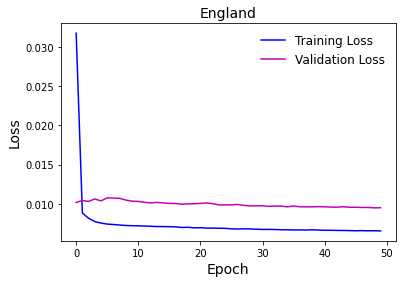

In [16]:
# Plot validation and training loss
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss',color='m')
plt.legend(fontsize=12,frameon=False)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title('England',fontsize=14)
plt.show()

In [17]:
# Predict the values
y_pred_en = lstm_model.predict(testX_en)

80/80 [==============================] - 3s 20ms/step


In [18]:
# calculate the accuracy matrics
#loss = lstm_model.evaluate(testY_en,y_pred_en)
mae = mean_absolute_error(testY_en, y_pred_en)
mse = mean_squared_error(testY_en, y_pred_en)
rmse = np.sqrt(mse) # or mse**(0.5)  

print("Results of accuracy metrics:")
print("MSE:", np.round(mse,3))
print("MAE:",np.round(mae,3))
print("RMSE:", np.round(rmse,3))


Results of accuracy metrics:
MSE: 0.012
MAE: 0.064
RMSE: 0.108


In [19]:
predict = y_pred_en.reshape(-1)

In [20]:
eng = pd.DataFrame({'date':dateTest,'actual':testY_en,'predict':predict})

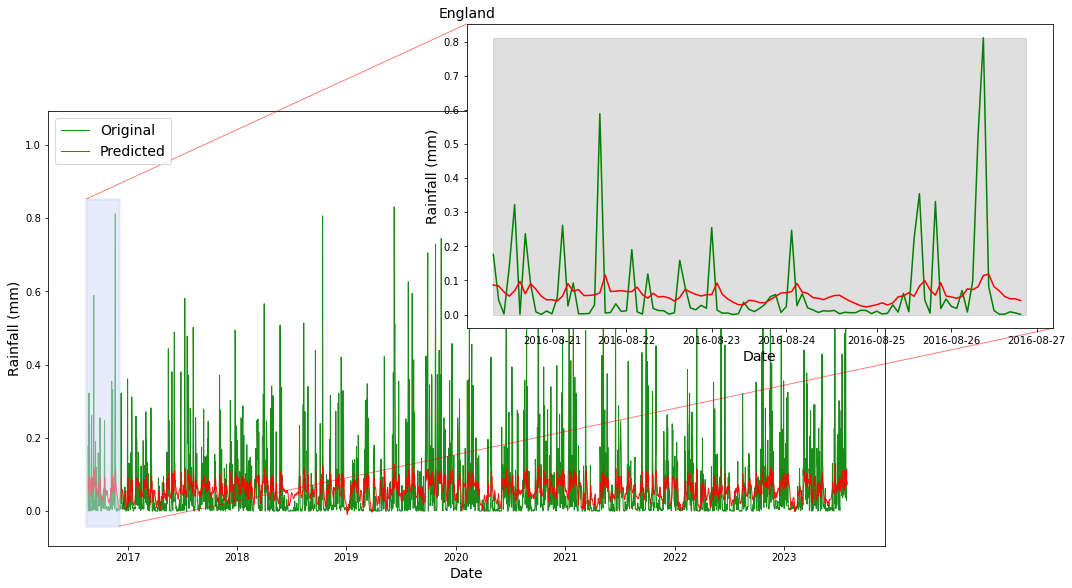

In [21]:
# Create a figure and axis for the full plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the full dataset
ax.plot(eng['date'], eng['actual'], label='Original', linewidth=1, color='g',alpha=0.9)
ax.plot(eng['date'], eng['predict'], label='Predicted', linewidth=1,color='r',alpha=0.9)

# Create a zoomed-in axis for the first 100 data points
axins = ax.inset_axes([0.5, 0.5, 0.7, 0.7])   

# Plot the zoomed-in portion (first 100 values)
axins.plot(eng['date'][:100], eng['actual'][:100], linewidth=1.5, color='g')
axins.plot(eng['date'][:100], eng['predict'][:100],linewidth=1.5,color='r')

# Format x-axis tick labels for the full plot
date_labels = [date.strftime('%Y-%m-%d') for date in eng['date'][:100]]
# Set x-axis tick labels angled by 70 degrees
axins.set_xticklabels(date_labels)
#axins.set_xticklabels(pd.to_datetime(eng['date'][:100]), rotation=70)

# Set labels for both axes
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rainfall (mm)', fontsize=14)
axins.set_xlabel('Date', fontsize=14)
axins.set_ylabel('Rainfall (mm)', fontsize=14)
# Increase the y-limit for the zoomed-in plot
#ax.set_ylim(0, 1.5)  # Adjust the limits as needed
# Create a rectangle patch to highlight the zoomed-in area
x1, x2, y1, y2 = eng['date'][0], eng['date'][100], min(eng['actual'][:100]), max(eng['actual'][:100])
axins.fill_between([x1, x2], y1, y2, alpha=0.25, color='gray')

ax.indicate_inset_zoom(axins, color='#cedbf5', edgecolor="red", linewidth=2.5)

# Add a legend
ax.legend(loc='upper left', fontsize=14)

plt.title("England", fontsize=14)
# Show the plot
plt.show()


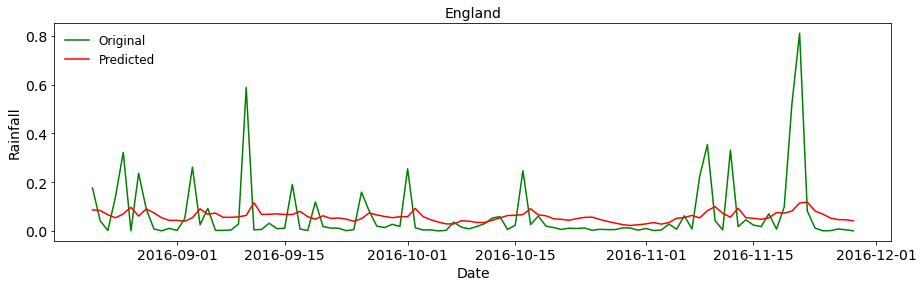

In [22]:
# Plot predicted vs. original values
dateTest=pd.to_datetime(dateTest)
plt.figure(figsize=(15, 4))
plt.plot(eng['date'][:100], eng['actual'][:100], label='Original',color='g')
plt.plot(eng['date'][:100], eng['predict'][:100], label='Predicted',color='r')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Rainfall',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('England',fontsize=14)
plt.legend(fontsize=12,frameon=False)
plt.show()

### Make forecasting and Plot Results

In [22]:
#forecasting...
n_future = 30
data_en['date']=pd.to_datetime(data_en['date'])
forcast_period_date = pd.date_range(list(data_en['date'])[-1],periods=n_future,freq='1d').tolist()

forecast_en = lstm_model.predict(testX_en[-n_future:]) #forecast 

1/1 [==============================] - 0s 34ms/step


In [23]:
#preform inverse transformation to rescale back to original range
forecast_en = forecast_en.reshape(-1, 1)
forecast_copies = np.repeat(forecast_en, trainX_en.shape[2], axis=-1)

In [24]:
y_pred_future_en = scaler.inverse_transform(forecast_copies)[:,0]

In [25]:
forecast_dates = []

#forecast = forecast.reshape(-1)

for time_i in forcast_period_date:
    forecast_dates.append(time_i.date())
    
df_forecast_en = pd.DataFrame({'date':np.array(forecast_dates), 'Rainfall':y_pred_future_en})
df_forecast_en['date']=pd.to_datetime(df_forecast_en['date'])


original = data_en[['date', 'Rainfall']]
original['date']=pd.to_datetime(original['date'])

In [26]:
original = original.loc[(original['date'] >= '2023-07-01') & (original['date'] <= '2023-07-31')]

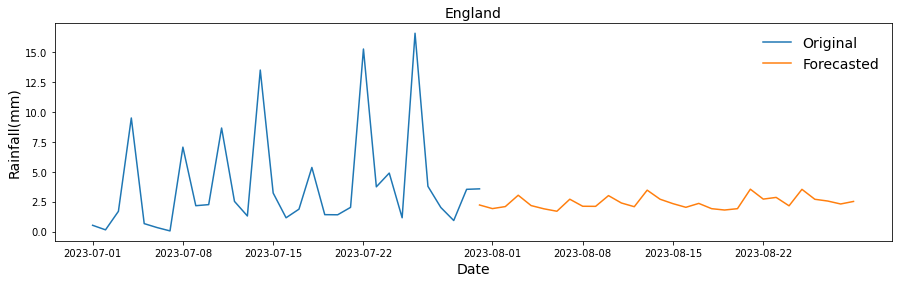

In [27]:
# plotting forecasted and original rainfall data
plt.figure(figsize=(15,4))
plt.plot(original['date'], original['Rainfall'],label='Original')
plt.plot(df_forecast_en['date'], df_forecast_en['Rainfall'],label="Forecasted")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Rainfall(mm)",fontsize=14)
plt.title("England", fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.show()

## Wales

In [28]:
target_col = 'Rainfall'

# Extract the target variable
target_wl = data_wl[target_col].values
df_dates = data_wl['date']
df_wl =data_wl.drop(columns=['date'])

In [29]:
#split test and train
train_split=round(len(df_wl)*0.67)
df_for_training_wl=df_wl[:train_split]
df_temp_wl=df_wl[train_split:]
test_split=round(len(df_temp_wl)*0.5)
df_for_validation_wl=df_temp_wl[:test_split]
df_for_testing_wl=df_temp_wl[test_split:]

In [30]:
print("df_for_training Shape-- ",df_for_training_wl.shape)
print("df_for_validation Shape-- ",df_for_validation_wl.shape)
print("df_for_testing Shape-- ",df_for_testing_wl.shape)

df_for_training Shape--  (10419, 7)
df_for_validation Shape--  (2566, 7)
df_for_testing Shape--  (2566, 7)


In [31]:
#split test dates
temp_date=df_dates[train_split:]
df_for_testdate=temp_date[test_split:]

In [32]:
# scale the dataset with minmaxscaler within the range 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled_wl = scaler.fit_transform(df_for_training_wl)
df_for_validation_scaled_wl = scaler.fit_transform(df_for_validation_wl)
df_for_testing_scaled_wl=scaler.transform(df_for_testing_wl)

In [33]:
# Define the number of time steps and features
n_steps = 15  # Number of time steps to consider
n_features = df_for_testing_scaled_wl.shape[1]

In [34]:
# split the data in X and Y
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #print(i)
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX_wl,trainY_wl=createXY(df_for_training_scaled_wl,n_steps)
valX_wl,valY_wl=createXY(df_for_validation_scaled_wl,n_steps)
testX_wl,testY_wl=createXY(df_for_testing_scaled_wl,n_steps)

In [35]:
print("trainX Shape-- ",trainX_wl.shape)
print("trainY Shape-- ",testX_wl.shape)

trainX Shape--  (10404, 15, 7)
trainY Shape--  (2551, 15, 7)


In [36]:
df_for_testdate = df_for_testdate.reset_index()

In [37]:
# split the date
def createtestDate(dataset,n_past):
    dateTest = []
    for i in range(n_past, len(dataset)):
            #print(i)
            dateTest.append(dataset.date[i])
    return np.array(dateTest)
dateTest=createtestDate(df_for_testdate,n_steps)

## Rainfall Forecasting Using Bidirectional LSTM implementation

In [38]:
# design network
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(units=64,activation='sigmoid',return_sequences=True, input_shape=(n_steps,n_features))))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1,activation='tanh'))
opt = optimizers.Adam(learning_rate=0.001)
lstm_model.compile(loss = 'mse',optimizer = opt)

In [39]:
# fit network
history = lstm_model.fit(trainX_wl, trainY_wl, epochs=50, batch_size=64, validation_data=(valX_wl, valY_wl), verbose=2, shuffle=False)

Epoch 1/50
163/163 - 11s - loss: 0.0231 - val_loss: 0.0191 - 11s/epoch - 65ms/step
Epoch 2/50
163/163 - 4s - loss: 0.0154 - val_loss: 0.0197 - 4s/epoch - 26ms/step
Epoch 3/50
163/163 - 4s - loss: 0.0147 - val_loss: 0.0196 - 4s/epoch - 25ms/step
Epoch 4/50
163/163 - 4s - loss: 0.0143 - val_loss: 0.0191 - 4s/epoch - 24ms/step
Epoch 5/50
163/163 - 4s - loss: 0.0142 - val_loss: 0.0189 - 4s/epoch - 24ms/step
Epoch 6/50
163/163 - 4s - loss: 0.0140 - val_loss: 0.0186 - 4s/epoch - 25ms/step
Epoch 7/50
163/163 - 4s - loss: 0.0138 - val_loss: 0.0186 - 4s/epoch - 25ms/step
Epoch 8/50
163/163 - 4s - loss: 0.0137 - val_loss: 0.0183 - 4s/epoch - 24ms/step
Epoch 9/50
163/163 - 4s - loss: 0.0135 - val_loss: 0.0183 - 4s/epoch - 26ms/step
Epoch 10/50
163/163 - 4s - loss: 0.0134 - val_loss: 0.0182 - 4s/epoch - 26ms/step
Epoch 11/50
163/163 - 4s - loss: 0.0132 - val_loss: 0.0178 - 4s/epoch - 25ms/step
Epoch 12/50
163/163 - 4s - loss: 0.0132 - val_loss: 0.0175 - 4s/epoch - 24ms/step
Epoch 13/50
163/163 - 4

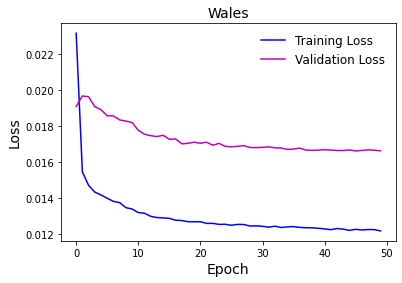

In [40]:
# Plot validation and training loss
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss',color='m')
plt.legend(fontsize=12,frameon=False)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title('Wales', fontsize=14)
plt.show()

In [41]:
# Predict the values
y_pred_wl = lstm_model.predict(testX_wl)

80/80 [==============================] - 2s 7ms/step


In [42]:
# calculate the accuracy matrics
mae = mean_absolute_error(testY_wl, y_pred_wl)
mse = mean_squared_error(testY_wl, y_pred_wl)
rmse = np.sqrt(mse) # or mse**(0.5)  

print("Results of accuracy metrics:")
print("MAE:",np.round(mae,3))
print("MSE:", np.round(mse,3))
print("RMSE:", np.round(rmse,3))


Results of accuracy metrics:
MAE: 0.089
MSE: 0.023
RMSE: 0.151


In [43]:
predict = y_pred_wl.reshape(-1)

In [44]:
eng = pd.DataFrame({'date':dateTest,'actual':testY_wl,'predict':predict})

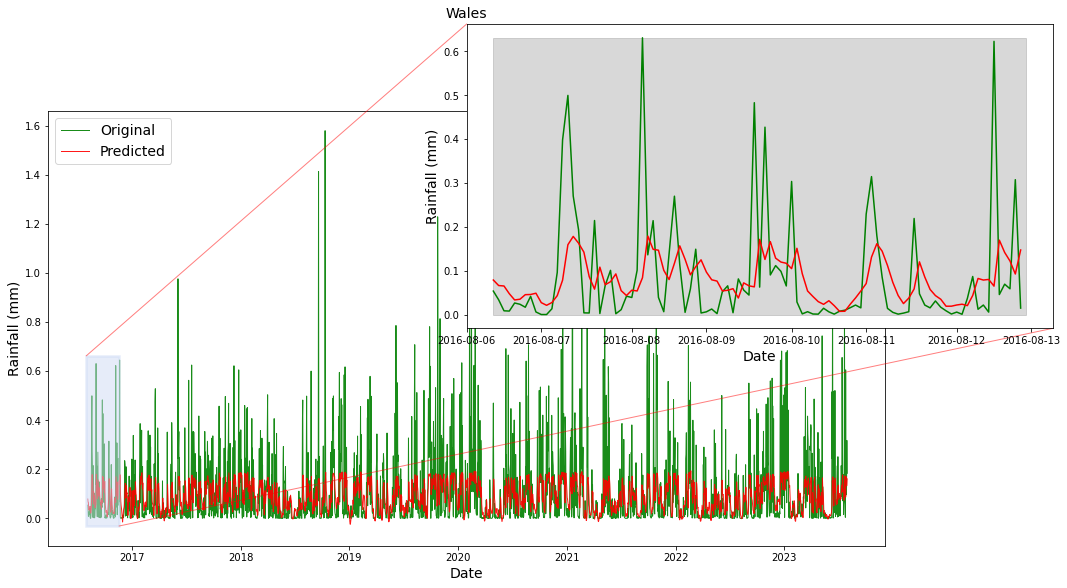

In [45]:
# Create a figure and axis for the full plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the full dataset
ax.plot(eng['date'], eng['actual'], label='Original', linewidth=1, color='g',alpha=0.9)
ax.plot(eng['date'], eng['predict'], label='Predicted', linewidth=1,color='r',alpha=0.9)

# Create a zoomed-in axis for the first 100 data points
axins = ax.inset_axes([0.5, 0.5, 0.7, 0.7])   

# Plot the zoomed-in portion (first 100 values)
axins.plot(eng['date'][:100], eng['actual'][:100], linewidth=1.5, color='g')
axins.plot(eng['date'][:100], eng['predict'][:100],linewidth=1.5,color='r')

# Format x-axis tick labels for the full plot
date_labels = [date.strftime('%Y-%m-%d') for date in eng['date'][:100]]
# Set x-axis tick labels angled by 70 degrees
axins.set_xticklabels(date_labels)
#axins.set_xticklabels(pd.to_datetime(eng['date'][:100]), rotation=70)

# Set labels for both axes
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rainfall (mm)', fontsize=14)
axins.set_xlabel('Date', fontsize=14)
axins.set_ylabel('Rainfall (mm)', fontsize=14)
# Increase the y-limit for the zoomed-in plot
#ax.set_ylim(0, 1.5)  # Adjust the limits as needed
# Create a rectangle patch to highlight the zoomed-in area
x1, x2, y1, y2 = eng['date'][0], eng['date'][100], min(eng['actual'][:100]), max(eng['actual'][:100])
axins.fill_between([x1, x2], y1, y2, alpha=0.3, color='gray')

ax.indicate_inset_zoom(axins, color='#cedbf5', edgecolor="red", linewidth=2.5)

# Add a legend
ax.legend(loc='upper left', fontsize=14)
plt.title('Wales', fontsize=14)
# Show the plot
plt.show()


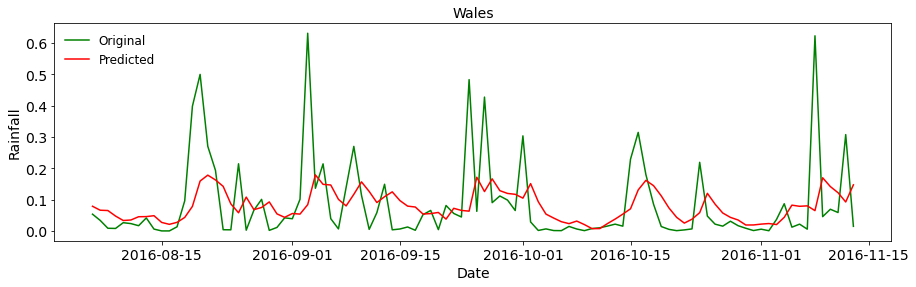

In [46]:
# Plot predicted vs. original values
dateTest=pd.to_datetime(dateTest)
plt.figure(figsize=(15, 4))
plt.plot(eng['date'][:100], eng['actual'][:100], label='Original',color='g')
plt.plot(eng['date'][:100], eng['predict'][:100], label='Predicted',color='r')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Rainfall',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Wales',fontsize=14)
plt.legend(fontsize=12,frameon=False)
plt.show()

### Make forecasting and Plot Results

In [47]:
#forecasting...
n_future = 30
data_wl['date']=pd.to_datetime(data_wl['date'])
forcast_period_date = pd.date_range(list(data_wl['date'])[-1],periods=n_future,freq='1d').tolist()

forecast_wl = lstm_model.predict(testX_wl[-n_future:]) #forecast 

1/1 [==============================] - 0s 26ms/step


In [48]:
#preform inverse transformation to rescale back to original range
forecast_wl = forecast_wl.reshape(-1, 1)
forecast_copies = np.repeat(forecast_wl, trainX_wl.shape[2], axis=-1)

In [49]:
y_pred_future_wl = scaler.inverse_transform(forecast_copies)[:,0]

In [50]:
forecast_dates = []

#forecast = forecast.reshape(-1)

for time_i in forcast_period_date:
    forecast_dates.append(time_i.date())
    
df_forecast_wl = pd.DataFrame({'date':np.array(forecast_dates), 'Rainfall':y_pred_future_wl})
df_forecast_wl['date']=pd.to_datetime(df_forecast_wl['date'])


original = data_wl[['date', 'Rainfall']]
original['date']=pd.to_datetime(original['date'])

In [51]:
original = original.loc[(original['date'] >= '2023-07-01') & (original['date'] <= '2023-07-31')]

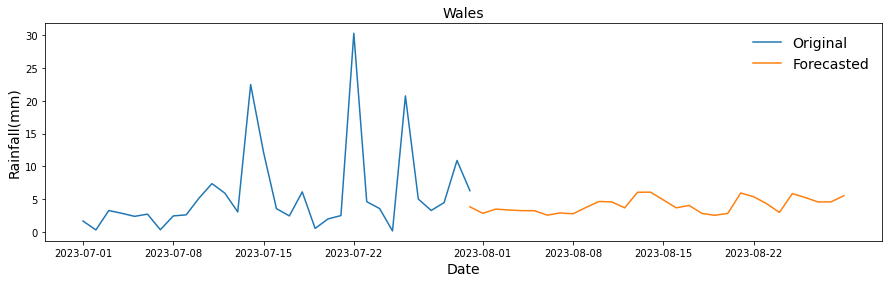

In [52]:
# plotting forecasted and original rainfall data
plt.figure(figsize=(15,4))
plt.plot(original['date'], original['Rainfall'],label='Original')
plt.plot(df_forecast_wl['date'], df_forecast_wl['Rainfall'],label="Forecasted")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Rainfall(mm)",fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.title("Wales", fontsize=14)
plt.show()

## Scotland

In [35]:
target_col = 'Rainfall'

# Extract the target variable
target_sc = data_sc[target_col].values
df_dates = data_sc['date']
df_sc =data_sc.drop(columns=['date'])

In [36]:
#split test and train
train_split=round(len(df_sc)*0.67)
df_for_training_sc=df_sc[:train_split]
df_temp_sc=df_sc[train_split:]
test_split=round(len(df_temp_sc)*0.5)
df_for_validation_sc=df_temp_sc[:test_split]
df_for_testing_sc=df_temp_sc[test_split:]

In [37]:
print("df_for_training Shape-- ",df_for_training_sc.shape)
print("df_for_validation Shape-- ",df_for_validation_sc.shape)
print("df_for_testing Shape-- ",df_for_testing_sc.shape)

df_for_training Shape--  (10419, 7)
df_for_validation Shape--  (2566, 7)
df_for_testing Shape--  (2566, 7)


In [38]:
#split test dates
temp_date=df_dates[train_split:]
df_for_testdate=temp_date[test_split:]

In [39]:
# scale the dataset with minmaxscaler within the range 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled_sc = scaler.fit_transform(df_for_training_sc)
df_for_validation_scaled_sc = scaler.fit_transform(df_for_validation_sc)
df_for_testing_scaled_sc=scaler.transform(df_for_testing_sc)

In [40]:
# Define the number of time steps and features
n_steps = 30  # Number of time steps to consider
n_features = df_for_testing_scaled_sc.shape[1]

In [41]:
# split the data in X and Y
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #print(i)
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX_sc,trainY_sc=createXY(df_for_training_scaled_sc,n_steps)
valX_sc,valY_sc=createXY(df_for_validation_scaled_sc,n_steps)
testX_sc,testY_sc=createXY(df_for_testing_scaled_sc,n_steps)

In [42]:
print("trainX Shape-- ",trainX_sc.shape)
print("trainY Shape-- ",testX_sc.shape)

trainX Shape--  (10389, 30, 7)
trainY Shape--  (2536, 30, 7)


In [43]:
df_for_testdate = df_for_testdate.reset_index()

In [44]:
# split the date
def createtestDate(dataset,n_past):
    dateTest = []
    for i in range(n_past, len(dataset)):
            #print(i)
            dateTest.append(dataset.date[i])
    return np.array(dateTest)
dateTest=createtestDate(df_for_testdate,n_steps)

## Rainfall Forecasting Using Bidirectional LSTM implementation

In [45]:
# design network
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(units=64,activation='sigmoid',return_sequences=True, input_shape=(n_steps,n_features))))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1,activation='tanh'))
opt = optimizers.Adam(learning_rate=0.001)
lstm_model.compile(loss = 'mse',optimizer = opt)

In [46]:
# fit network
history = lstm_model.fit(trainX_sc, trainY_sc, epochs=50, batch_size=64, validation_data=(valX_sc, valY_sc), verbose=2, shuffle=False)

Epoch 1/50
163/163 - 102s - loss: 0.0264 - val_loss: 0.0158 - 102s/epoch - 625ms/step
Epoch 2/50
163/163 - 24s - loss: 0.0152 - val_loss: 0.0161 - 24s/epoch - 148ms/step
Epoch 3/50
163/163 - 31s - loss: 0.0144 - val_loss: 0.0161 - 31s/epoch - 189ms/step
Epoch 4/50
163/163 - 27s - loss: 0.0139 - val_loss: 0.0161 - 27s/epoch - 168ms/step
Epoch 5/50
163/163 - 35s - loss: 0.0136 - val_loss: 0.0161 - 35s/epoch - 217ms/step
Epoch 6/50
163/163 - 32s - loss: 0.0135 - val_loss: 0.0157 - 32s/epoch - 197ms/step
Epoch 7/50
163/163 - 27s - loss: 0.0133 - val_loss: 0.0155 - 27s/epoch - 168ms/step
Epoch 8/50
163/163 - 28s - loss: 0.0130 - val_loss: 0.0155 - 28s/epoch - 171ms/step
Epoch 9/50
163/163 - 30s - loss: 0.0129 - val_loss: 0.0151 - 30s/epoch - 187ms/step
Epoch 10/50
163/163 - 38s - loss: 0.0128 - val_loss: 0.0150 - 38s/epoch - 232ms/step
Epoch 11/50
163/163 - 36s - loss: 0.0126 - val_loss: 0.0149 - 36s/epoch - 223ms/step
Epoch 12/50
163/163 - 27s - loss: 0.0124 - val_loss: 0.0147 - 27s/epoch 

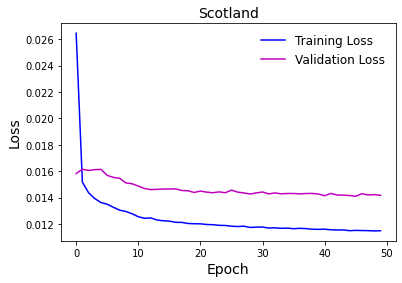

In [47]:
# Plot validation and training loss
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss',color='m')
plt.legend(fontsize=12,frameon=False)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title('Scotland', fontsize=14)
plt.show()

In [48]:
# Predict the values
y_pred_sc = lstm_model.predict(testX_sc)

80/80 [==============================] - 24s 52ms/step


In [49]:
# calculate the accuracy matrics
mae = mean_absolute_error(testY_sc, y_pred_sc)
mse = mean_squared_error(testY_sc, y_pred_sc)
rmse = np.sqrt(mse) # or mse**(0.5)  

print("Results of accuracy metrics:")
print("MSE:", np.round(mse,3))
print("MAE:",np.round(mae,3))
print("RMSE:", np.round(rmse,3))


Results of accuracy metrics:
MSE: 0.014
MAE: 0.076
RMSE: 0.117


In [50]:
predict = y_pred_sc.reshape(-1)

In [51]:
eng = pd.DataFrame({'date':dateTest,'actual':testY_sc,'predict':predict})

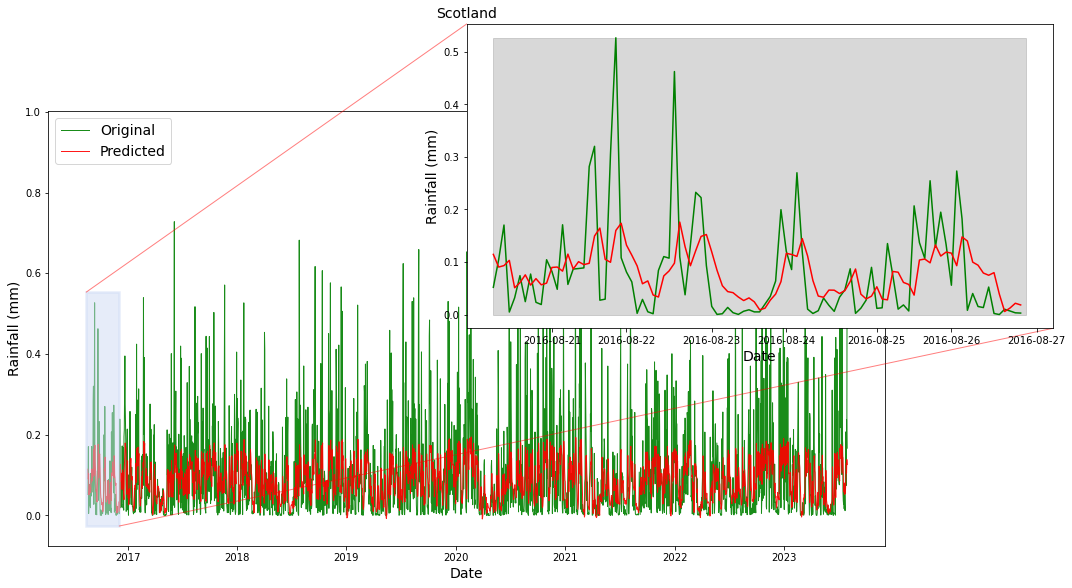

In [52]:
# Create a figure and axis for the full plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the full dataset
ax.plot(eng['date'], eng['actual'], label='Original', linewidth=1, color='g',alpha=0.9)
ax.plot(eng['date'], eng['predict'], label='Predicted', linewidth=1,color='r',alpha=0.9)

# Create a zoomed-in axis for the first 100 data points
axins = ax.inset_axes([0.5, 0.5, 0.7, 0.7])   

# Plot the zoomed-in portion (first 100 values)
axins.plot(eng['date'][:100], eng['actual'][:100], linewidth=1.5, color='g')
axins.plot(eng['date'][:100], eng['predict'][:100],linewidth=1.5,color='r')

# Format x-axis tick labels for the full plot
date_labels = [date.strftime('%Y-%m-%d') for date in eng['date'][:100]]
# Set x-axis tick labels angled by 70 degrees
axins.set_xticklabels(date_labels)
#axins.set_xticklabels(pd.to_datetime(eng['date'][:100]), rotation=70)

# Set labels for both axes
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rainfall (mm)', fontsize=14)
axins.set_xlabel('Date', fontsize=14)
axins.set_ylabel('Rainfall (mm)', fontsize=14)
# Increase the y-limit for the zoomed-in plot
#ax.set_ylim(0, 1.5)  # Adjust the limits as needed
# Create a rectangle patch to highlight the zoomed-in area
x1, x2, y1, y2 = eng['date'][0], eng['date'][100], min(eng['actual'][:100]), max(eng['actual'][:100])
axins.fill_between([x1, x2], y1, y2, alpha=0.3, color='gray')

ax.indicate_inset_zoom(axins, color='#cedbf5', edgecolor="red", linewidth=2.5)

# Add a legend
ax.legend(loc='upper left', fontsize=14)
plt.title('Scotland', fontsize=14)
# Show the plot
plt.show()


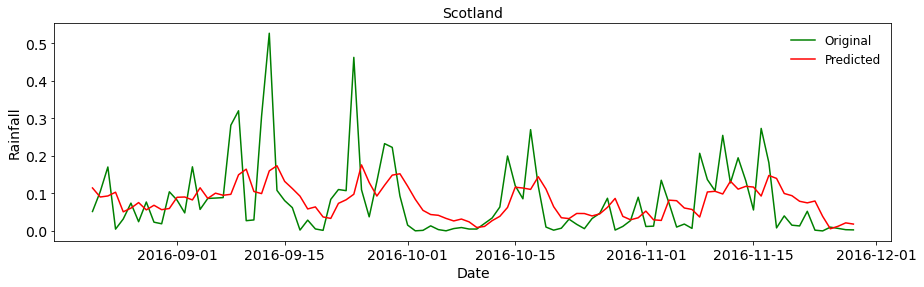

In [53]:
# Plot predicted vs. original values
dateTest=pd.to_datetime(dateTest)
plt.figure(figsize=(15, 4))
plt.plot(eng['date'][:100], eng['actual'][:100], label='Original',color='g')
plt.plot(eng['date'][:100], eng['predict'][:100], label='Predicted',color='r')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Rainfall',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Scotland',fontsize=14)
plt.legend(fontsize=12,frameon=False)
plt.show()

### Make forecasting and Plot Results

In [54]:
#forecasting...
n_future = 30
data_sc['date']=pd.to_datetime(data_sc['date'])
forcast_period_date = pd.date_range(list(data_sc['date'])[-2],periods=n_future,freq='1d').tolist()

forecast_sc = lstm_model.predict(testX_sc[-n_future:]) #forecast 

1/1 [==============================] - 0s 483ms/step


In [55]:
#preform inverse transformation to rescale back to original range
forecast_sc = forecast_sc.reshape(-1, 1)
forecast_copies = np.repeat(forecast_sc, trainX_sc.shape[2], axis=-1)

In [56]:
y_pred_future_sc = scaler.inverse_transform(forecast_copies)[:,0]

In [57]:
forecast_dates = []

#forecast = forecast.reshape(-1)

for time_i in forcast_period_date:
    forecast_dates.append(time_i.date())
    
df_forecast_sc = pd.DataFrame({'date':np.array(forecast_dates), 'Rainfall':y_pred_future_sc})
df_forecast_sc['date']=pd.to_datetime(df_forecast_sc['date'])


original = data_sc[['date', 'Rainfall']]
original['date']=pd.to_datetime(original['date'])

In [58]:
original = original.loc[(original['date'] >= '2023-07-01') & (original['date'] < '2023-07-31')]

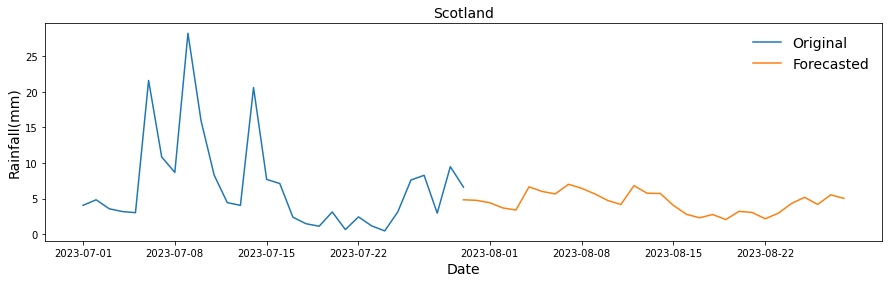

In [59]:
# plotting forecasted and original rainfall data
plt.figure(figsize=(15,4))
plt.plot(original['date'], original['Rainfall'],label='Original')
plt.plot(df_forecast_sc['date'], df_forecast_sc['Rainfall'],label="Forecasted")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Rainfall(mm)",fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.title("Scotland", fontsize=14)
plt.show()

In [29]:
######################################################################

## Northern Ireland

In [130]:
target_col = 'Rainfall'

# Extract the target variable
target_ir = data_ir[target_col].values
df_dates = data_ir['date']
df_ir =data_ir.drop(columns=['date'])

In [131]:
#split test and train
train_split=round(len(df_ir)*0.7)
df_for_training_ir=df_ir[:train_split]
df_temp_ir=df_ir[train_split:]
test_split=round(len(df_temp_ir)*0.5)
df_for_validation_ir=df_temp_ir[:test_split]
df_for_testing_ir=df_temp_ir[test_split:]

In [132]:
print("df_for_training Shape-- ",df_for_training_ir.shape)
print("df_for_validation Shape-- ",df_for_validation_ir.shape)
print("df_for_testing Shape-- ",df_for_testing_ir.shape)

df_for_training Shape--  (10886, 7)
df_for_validation Shape--  (2332, 7)
df_for_testing Shape--  (2333, 7)


In [133]:
#split test dates
temp_date=df_dates[train_split:]
df_for_testdate=temp_date[test_split:]

In [134]:
# scale the dataset with minmaxscaler within the range 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled_ir = scaler.fit_transform(df_for_training_ir)
df_for_validation_scaled_ir = scaler.fit_transform(df_for_validation_ir)
df_for_testing_scaled_ir=scaler.transform(df_for_testing_ir)

In [135]:
# Define the number of time steps and features
n_steps = 15  # Number of time steps to consider
n_features = df_for_testing_scaled_ir.shape[1]

In [136]:
# split the data in X and Y
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            #print(i)
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX_ir,trainY_ir=createXY(df_for_training_scaled_ir,n_steps)
valX_ir,valY_ir=createXY(df_for_validation_scaled_ir,n_steps)
testX_ir,testY_ir=createXY(df_for_testing_scaled_ir,n_steps)

In [137]:
print("trainX Shape-- ",trainX_ir.shape)
print("trainY Shape-- ",testX_ir.shape)

trainX Shape--  (10871, 15, 7)
trainY Shape--  (2318, 15, 7)


In [138]:
df_for_testdate = df_for_testdate.reset_index()

In [139]:
# split the date
def createtestDate(dataset,n_past):
    dateTest = []
    for i in range(n_past, len(dataset)):
            #print(i)
            dateTest.append(dataset.date[i])
    return np.array(dateTest)
dateTest=createtestDate(df_for_testdate,n_steps)

## Rainfall Forecasting Using Bidirectional LSTM implementation

In [140]:
# design network
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(units=100,activation='sigmoid',return_sequences=True, input_shape=(n_steps,n_features))))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1,activation='tanh'))
opt = optimizers.Adam(learning_rate=0.001)
lstm_model.compile(loss = 'mse',optimizer = opt)

In [141]:
# fit network
history = lstm_model.fit(trainX_ir, trainY_ir, epochs=50, batch_size=72, validation_data=(valX_ir, valY_ir), verbose=2, shuffle=False)

Epoch 1/50
151/151 - 13s - loss: 0.0272 - val_loss: 0.0119 - 13s/epoch - 86ms/step
Epoch 2/50
151/151 - 7s - loss: 0.0111 - val_loss: 0.0118 - 7s/epoch - 48ms/step
Epoch 3/50
151/151 - 8s - loss: 0.0103 - val_loss: 0.0117 - 8s/epoch - 52ms/step
Epoch 4/50
151/151 - 8s - loss: 0.0100 - val_loss: 0.0117 - 8s/epoch - 51ms/step
Epoch 5/50
151/151 - 8s - loss: 0.0099 - val_loss: 0.0118 - 8s/epoch - 50ms/step
Epoch 6/50
151/151 - 8s - loss: 0.0098 - val_loss: 0.0118 - 8s/epoch - 52ms/step
Epoch 7/50
151/151 - 8s - loss: 0.0097 - val_loss: 0.0117 - 8s/epoch - 50ms/step
Epoch 8/50
151/151 - 8s - loss: 0.0096 - val_loss: 0.0116 - 8s/epoch - 56ms/step
Epoch 9/50
151/151 - 8s - loss: 0.0096 - val_loss: 0.0116 - 8s/epoch - 53ms/step
Epoch 10/50
151/151 - 8s - loss: 0.0095 - val_loss: 0.0116 - 8s/epoch - 54ms/step
Epoch 11/50
151/151 - 8s - loss: 0.0095 - val_loss: 0.0115 - 8s/epoch - 52ms/step
Epoch 12/50
151/151 - 9s - loss: 0.0094 - val_loss: 0.0115 - 9s/epoch - 56ms/step
Epoch 13/50
151/151 - 8

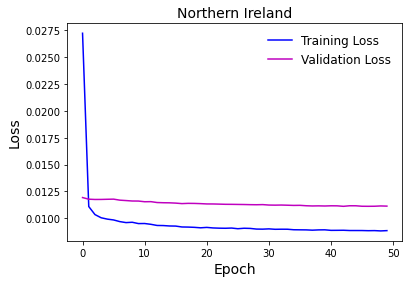

In [142]:
# Plot validation and training loss
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss',color='m')
plt.legend(fontsize=12,frameon=False)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title('Northern Ireland', fontsize=14)
plt.show()

In [143]:
# Predict the values
y_pred_ir = lstm_model.predict(testX_ir)

73/73 [==============================] - 3s 17ms/step


In [144]:
# calculate the accuracy matrics
mae = mean_absolute_error(testY_ir, y_pred_ir)
mse = mean_squared_error(testY_ir, y_pred_ir)
rmse = np.sqrt(mse) # or mse**(0.5)  

print("Results of accuracy metrics:")
print("MsE:",np.round(mse,3))
print("MAE:",np.round(mae,3))
print("RMSE:", np.round(rmse,3))


Results of accuracy metrics:
MsE: 0.011
MAE: 0.07
RMSE: 0.107


In [145]:
predict = y_pred_ir.reshape(-1)

In [146]:
eng = pd.DataFrame({'date':dateTest,'actual':testY_ir,'predict':predict})

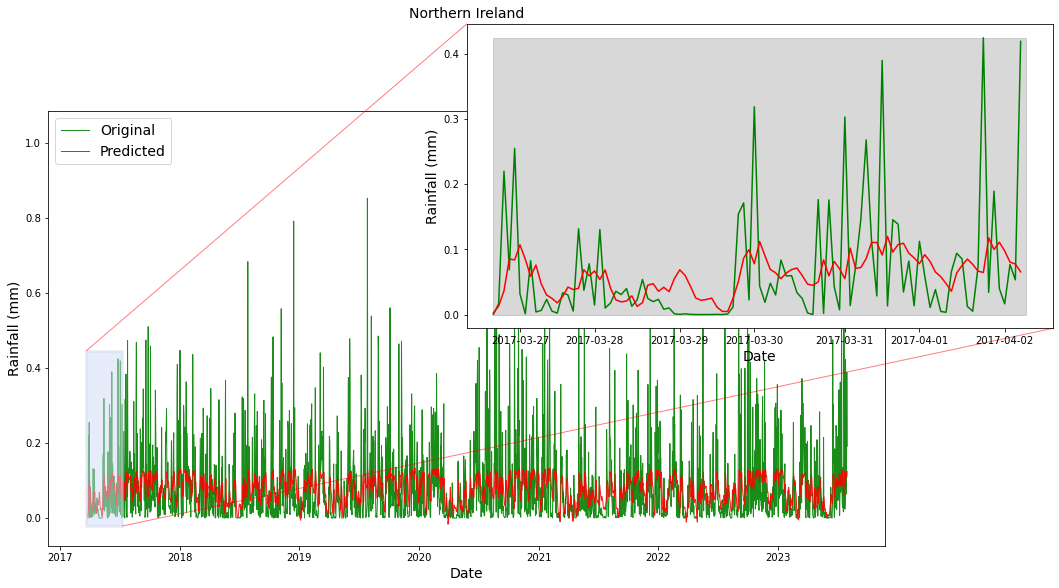

In [147]:
# Create a figure and axis for the full plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the full dataset
ax.plot(eng['date'], eng['actual'], label='Original', linewidth=1, color='g',alpha=0.9)
ax.plot(eng['date'], eng['predict'], label='Predicted', linewidth=1,color='r',alpha=0.9)

# Create a zoomed-in axis for the first 100 data points
axins = ax.inset_axes([0.5, 0.5, 0.7, 0.7])   

# Plot the zoomed-in portion (first 100 values)
axins.plot(eng['date'][:100], eng['actual'][:100], linewidth=1.5, color='g')
axins.plot(eng['date'][:100], eng['predict'][:100],linewidth=1.5,color='r')

# Format x-axis tick labels for the full plot
date_labels = [date.strftime('%Y-%m-%d') for date in eng['date'][:100]]
# Set x-axis tick labels angled by 70 degrees
axins.set_xticklabels(date_labels)
#axins.set_xticklabels(pd.to_datetime(eng['date'][:100]), rotation=70)

# Set labels for both axes
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rainfall (mm)', fontsize=14)
axins.set_xlabel('Date', fontsize=14)
axins.set_ylabel('Rainfall (mm)', fontsize=14)
# Increase the y-limit for the zoomed-in plot
#ax.set_ylim(0, 1.5)  # Adjust the limits as needed
# Create a rectangle patch to highlight the zoomed-in area
x1, x2, y1, y2 = eng['date'][0], eng['date'][100], min(eng['actual'][:100]), max(eng['actual'][:100])
axins.fill_between([x1, x2], y1, y2, alpha=0.3, color='gray')

ax.indicate_inset_zoom(axins, color='#cedbf5', edgecolor="red", linewidth=2.5)

# Add a legend
ax.legend(loc='upper left', fontsize=14)
plt.title('Northern Ireland', fontsize=14)
# Show the plot
plt.show()


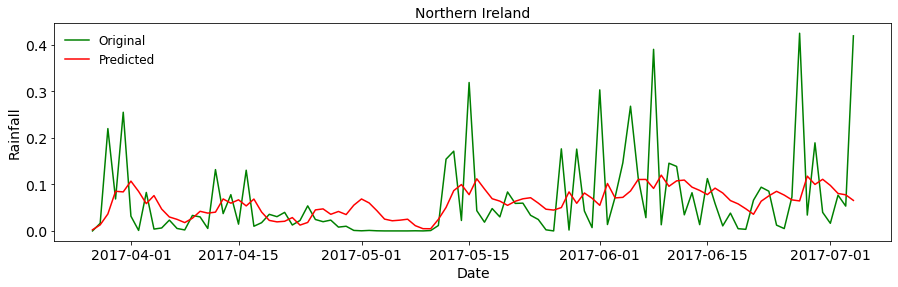

In [148]:
# Plot predicted vs. original values
dateTest=pd.to_datetime(dateTest)
plt.figure(figsize=(15, 4))
plt.plot(eng['date'][:100], eng['actual'][:100], label='Original',color='g')
plt.plot(eng['date'][:100], eng['predict'][:100], label='Predicted',color='r')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Rainfall',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Northern Ireland',fontsize=14)
plt.legend(fontsize=12,frameon=False)
plt.show()

### Make forecasting and Plot Results

In [113]:
#forecasting...
n_future = 30
data_ir['date']=pd.to_datetime(data_ir['date'])
forcast_period_date = pd.date_range(list(data_ir['date'])[-1],periods=n_future,freq='1d').tolist()

forecast_ir = lstm_model.predict(testX_ir[-n_future:]) #forecast 

1/1 [==============================] - 0s 31ms/step


In [114]:
#preform inverse transformation to rescale back to original range
forecast_ir = forecast_ir.reshape(-1, 1)
forecast_copies = np.repeat(forecast_ir, trainX_ir.shape[2], axis=-1)

In [115]:
y_pred_future_ir = scaler.inverse_transform(forecast_copies)[:,0]

In [116]:
forecast_dates = []

#forecast = forecast.reshape(-1)

for time_i in forcast_period_date:
    forecast_dates.append(time_i.date())
    
df_forecast_ir = pd.DataFrame({'date':np.array(forecast_dates), 'Rainfall':y_pred_future_ir})
df_forecast_ir['date']=pd.to_datetime(df_forecast_ir['date'])


original = data_ir[['date', 'Rainfall']]
original['date']=pd.to_datetime(original['date'])

In [117]:
original = original.loc[(original['date'] >= '2023-07-01') & (original['date'] <= '2023-07-31')]

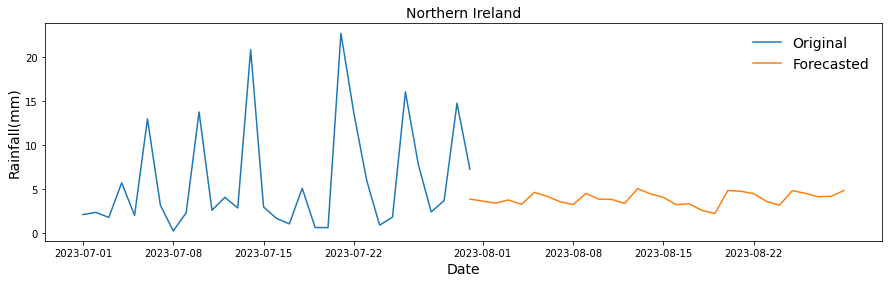

In [118]:
# plotting forecasted and original rainfall data
plt.figure(figsize=(15,4))
plt.plot(original['date'], original['Rainfall'],label='Original')
plt.plot(df_forecast_ir['date'], df_forecast_ir['Rainfall'],label="Forecasted")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Rainfall(mm)",fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.title('Northern Ireland', fontsize=14)
plt.show()